# Leaf Outline

In [1]:
def leaf_outline(image_path):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create masks for the calibration cube, leaf, and scars
    green_lower = np.array([35, 40, 40])
    green_upper = np.array([85, 255, 255])

    # Create masks for the calibration leaf
    green_mask = cv2.inRange(hsv_image, green_lower, green_upper)

    # Find contours of the leaf
    leaf_contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    leaf_contour = max(leaf_contours, key=cv2.contourArea)

    # Optionally display the results visually
    cv2.drawContours(image, [leaf_contour], -1, (0, 255, 0), 2)

    return image, leaf_contour

(-0.5, 1311.5, 1919.5, -0.5)

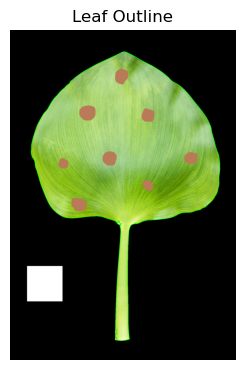

In [2]:
image, leaf_contour = leaf_outline("Leaf-with-scars-1.png")


import cv2
import matplotlib.pyplot as plt

# Display the segmented image
plt.subplot(1, 2, 1)
plt.title('Leaf Outline')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 432.5, 576.5, -0.5)

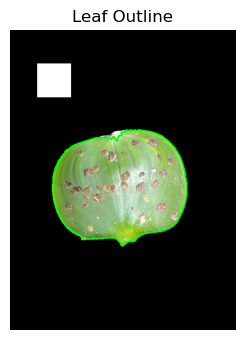

In [3]:
image, leaf_contour = leaf_outline("Leaf_1_Cube.png")


import cv2
import matplotlib.pyplot as plt

# Display the segmented image
plt.subplot(1, 2, 1)
plt.title('Leaf Outline')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Scar Counting

In [4]:
def scar_counting(image_path):
    import cv2
    import numpy as np

    # Load the water hyacinth scar image
    # image_path = r"Leaf_1.png"
    image = cv2.imread(image_path)
    # cv2.imshow("Original", image)

    # Copy the image for masking
    result = image.copy()

    # Convert image to HSV color space
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define HSV color range for brownish scars on water hyacinth
    lower_brown = np.array([10, 50, 20])   # Lower bound for brown hues
    upper_brown = np.array([20, 255, 200]) # Upper bound for brown hues

    # Create mask based on the defined brown color range
    brown_mask = cv2.inRange(image_hsv, lower_brown, upper_brown)

    # Apply mask to get only the brown regions
    result = cv2.bitwise_and(result, result, mask=brown_mask)

    # Find contours in the brown mask
    contours, _ = cv2.findContours(brown_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to keep track of merged contours
    merged_contours = []

    # Distance threshold in pixels (for 0.1 cm)
    distance_threshold = 10  # 0.1 cm in pixels (100 pixels/cm * 0.1 cm)

    # Process contours to merge close scars
    for contour in contours:
        if len(contour) > 0:
            # Calculate the centroid of the current contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                continue

            # Check if this centroid is too close to any existing merged contour centroid
            too_close = False
            for merged_contour in merged_contours:
                # Calculate the distance between the centroids
                merged_M = cv2.moments(merged_contour)
                merged_cX = int(merged_M["m10"] / merged_M["m00"])
                merged_cY = int(merged_M["m01"] / merged_M["m00"])

                distance = np.sqrt((cX - merged_cX) ** 2 + (cY - merged_cY) ** 2)
                if distance < distance_threshold:
                    too_close = True
                    break

            # If it's not too close to any merged contour, add it
            if not too_close:
                merged_contours.append(contour)

    # Count the number of merged scars
    scar_count = len(merged_contours)

    # Show results
    # print(f"Total scars identified (merged): {scar_count}")
    # cv2.imshow('Brown Mask', brown_mask)
    # cv2.imshow('Result with Brown Scars Highlighted', result)

    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return scar_count

In [5]:
scar_count = scar_counting("Leaf-with-scars-1.png")
print(f"Total scars identified (merged): {scar_count}")

Total scars identified (merged): 8


In [6]:
scar_count = scar_counting("Leaf_1_Cube.png")
print(f"Total scars identified (merged): {scar_count}")

Total scars identified (merged): 28


# Filtering Test

In [7]:
import cv2
import numpy as np
 
def analyze_leaf_images(front_image_path, back_image_path):
    def process_image(image_path):
        # Load the image
        frame = cv2.imread(image_path)
        if frame is None:
            return None
 
        # Convert the BGR color space of the image to HSV color space
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
 
        # Detect the white cube for pixel-to-cm ratio
        lower_white = np.array([0, 0, 200])  # Lower bound for white
        upper_white = np.array([180, 55, 255])  # Upper bound for white
        cube_mask = cv2.inRange(hsv, lower_white, upper_white)
        contours, _ = cv2.findContours(cube_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
        if len(contours) == 0:
            return None  # Return None if no cube found for calibration
 
        # Assuming the largest white contour is the cube
        cube_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cube_contour)
 
        if w == 0 or h == 0:
            return None
 
        # Pixel-to-cm ratio calculation
        cube_size_in_pixels = max(w, h)  # Taking the larger side
        pixel_to_cm_ratio = cube_size_in_pixels / 2.0  # 2 cm cube
 
        # Define color ranges for healthy and scar areas
        lower_Healthy = np.array([40, 100, 60])
        upper_Healthy = np.array([80, 255, 180])
        lower_Unhealthy = np.array([15, 100, 100])
        upper_Unhealthy = np.array([35, 255, 255])
        lower_Scar = np.array([0, 50, 50])
        upper_Scar = np.array([20, 150, 200])
 
        # Masks for healthy (green), unhealthy (yellow), and scar (brown)
        green_mask = cv2.inRange(hsv, lower_Healthy, upper_Healthy)
        yellow_mask = cv2.inRange(hsv, lower_Unhealthy, upper_Unhealthy)
        brown_mask = cv2.inRange(hsv, lower_Scar, upper_Scar)
 
        # Combine masks to detect the entire leaf area (including scarred regions)
        leaf_mask = cv2.bitwise_or(green_mask, brown_mask)
        leaf_mask = cv2.bitwise_or(leaf_mask, yellow_mask)
 
        # Calculate areas in pixels
        total_leaf_pixels = cv2.countNonZero(leaf_mask)
        scar_pixels = cv2.countNonZero(brown_mask)
 
        # Convert areas to cm² using the pixel-to-cm ratio
        lamina_area_cm2 = total_leaf_pixels / (pixel_to_cm_ratio ** 2)
        scar_area_cm2 = scar_pixels / (pixel_to_cm_ratio ** 2)
 
        # Calculate damage percentage
        damage_percentage = (scar_area_cm2 / lamina_area_cm2) * 100 if lamina_area_cm2 > 0 else 0
 
        # Leaf length and width in cm
        x_leaf, y_leaf, w_leaf, h_leaf = cv2.boundingRect(leaf_mask)
        lamina_length_cm = h_leaf / pixel_to_cm_ratio
        lamina_width_cm = w_leaf / pixel_to_cm_ratio
 
        # Create and return the dictionary with the rounded values
        return {
            "lamina_area": round(lamina_area_cm2, 2),
            "lamina_length": round(lamina_length_cm, 2),
            "lamina_width": round(lamina_width_cm, 2),
            "scar_count": 0,  
            "scar_area": round(scar_area_cm2, 2),
            "damagepercentage": round(damage_percentage, 2)
        }
 
    # Process front and back images
    front_data = process_image(front_image_path)
    back_data = process_image(back_image_path)
 
    return front_data, back_data

In [8]:
front_data, back_data = analyze_leaf_images("Leaf-with-scars-1.png", "Leaf_1_Cube.png")
front_data["scar_count"] = scar_counting("Leaf-with-scars-1.png")
back_data["scar_count"] = scar_counting("Leaf_1_Cube.png")
print(front_data)
print(back_data)

{'lamina_area': 13.48, 'lamina_length': 16.3, 'lamina_width': 10.39, 'scar_count': 8, 'scar_area': 3.55, 'damagepercentage': 26.38}
{'lamina_area': 2.32, 'lamina_length': 3.52, 'lamina_width': 4.15, 'scar_count': 28, 'scar_area': 0.32, 'damagepercentage': 13.63}
